In [1]:
# Imports for gplearn and pydotplus in order to see graph view

In [2]:
%pylab inline
from IPython.display import Image
import pydotplus

from gplearn.genetic import SymbolicRegressor
from gplearn.fitness import make_fitness

Populating the interactive namespace from numpy and matplotlib


In [3]:
#--Import the required libraries--
import math
import random
import matplotlib.pyplot as plt
import numpy as np

#--debug mode to report on evaluation of tree--
debug_eval = False



# Test function

 The test function is the oscillations that would occur for an A-Major cord, with 1 unit representing 1/1000th of a seccond. (Function found from stack exchange)
The test function is evaluated from -5.0 to 5.0 at intervals of 0.5 in order to determine the fitness of an individual 
In order to evaluate a individual on the full range, 50 points are used from -10.0 to 10.0. The function is graphed at 100 points.

In [4]:
#--Setup for the test function--

#test function definition
def test_func(x):
    #A-major cord where 1 = 1/1000th of a seccond
    return math.sin(880.0*math.pi*x/1000.0)+math.sin(1100.0*math.pi*x/1000.0)+math.sin(1320.0*math.pi*x/1000.0)
    
#position of values to evaluate function at
x_values = np.arange(-5.0,5.0,0.5)
y_values = np.asarray([test_func(point) for point in x_values])

#range of values to display
func_range = (-10.0,10.0)
#step size of display
func_graph_points = 100

# Setup the training data
here we will pick random floats in our test test range for it to train off of


In [75]:

#Range of x values on the function to sample from
train_range = (-5,5)
dist_range = abs(train_range[0])+abs(train_range[1])

num_samples = 100
train_x = (np.random.random_sample(num_samples)*dist_range) + train_range[0]
train_y = np.asarray([test_func(point) for point in train_x])

print(train_x.shape)
print(train_x)

#reshape the new array in to a num_samples by 1 array since we only have 1 feature
train_x = train_x.reshape(-1,1)

print(train_x.shape)
print(train_x)

(100,)
[ 1.91871602  1.92442608  3.14701766  0.91370207 -0.93049569  3.25022568
  0.83692995  4.25614822 -1.33146486 -2.35003122 -4.81569423  1.95375497
 -4.08001885 -4.85913253  2.4233943  -3.09855061 -2.94251398  0.77745838
 -4.6019933  -2.41042712  3.10866517  3.52078525 -2.96543001 -1.41360089
 -3.04173977  0.45998272  3.98058648  1.40564031  4.20105158  3.68115138
 -0.74352232 -3.35344636  2.54497976  4.70626252  3.44578841  1.82127001
  2.59251028 -1.62927174 -1.88760515 -1.34697778  1.94327716  3.95513474
 -3.28027385 -1.28152395 -0.12746999 -0.41948894  0.60289282 -0.30662678
 -3.0617504  -1.11629157 -4.01716189 -4.3710684  -4.84697479 -0.36746186
 -3.22232656 -1.69310077 -2.48294144 -0.12534093 -3.30141458 -0.60024332
  0.19124353  0.25141328  2.76985786  3.18902381 -0.20808299 -1.95995402
  2.33550214  2.73119597  4.33403235  4.70069214 -1.72226166  1.69162893
  0.23619182 -2.5691889  -0.02510468  2.75250173  2.49797208 -0.29209604
 -0.67797321 -2.33823011  1.20907101 -3.8078

# Custom Fitness function
Here is where the real usage of gplearn begins, here we define a fitness function that tests the diffrence from the result to the selected training values using RMSE. This function is actually built into gplearn, but figured it was better to show how to make your own fitness function

In [76]:
#fittness function

def _custom_fitness(y, y_pred, w):
    return np.sqrt(np.mean((y_pred-y)**2))

custom_fitness = make_fitness(_custom_fitness, greater_is_better=False)

# Symbolic regression

We run a symbolic regression on a 1000 individuals for 20 generations. There are three kinds of mutation, subtree, hoist, and point. The hoist mutation is the only type that differs significantly from what was talked about in class. In it, a random subtree is selected, then, a random subtree from within it is lifted to it’s root node. It is used to combat tree bloat, and it appears to be very effective. Without the hoist mutation, tree trees grew like redwoods.

In [77]:
#This part sets up the symbolic regressor
best_gp = SymbolicRegressor(population_size=1000,
                           generations=20, stopping_criteria=0,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=1.0, verbose=1,
                           parsimony_coefficient=0.001, random_state=0,
                           metric = custom_fitness,
                           function_set=('add', 'sub', 'mul', 'div',"sin")
                           )
#This part runs it on our data
best_gp.fit(train_x, train_y)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    31.57 469.61437542841827        4 0.9557267615502556              N/A      5.80s
   1    16.63 5.842204561506758       21 0.8385804127045062              N/A     21.26s
   2     13.0 2.163542120320829       21 0.8385804127045062              N/A     22.41s
   3     9.43 1.7798702402746094       23 0.8099089719990347              N/A     21.48s
   4     16.5 1.5169939114750772       21 0.802831305972914              N/A     21.42s
   5    20.97 1.2883294841167559       44 0.7989779777772433              N/A     22.06s
   6    21.67 1.2980156204283626       44 0.7989779777772433              N/A     21.49s
   7    21.39 2.7173248489666313       58 0.7955140422440866              N/A     20.91s
   8    18.33 1.2464329627211024       35 0.78

SymbolicRegressor(const_range=(-1.0, 1.0),
         function_set=('add', 'sub', 'mul', 'div', 'sin'), generations=20,
         init_depth=(2, 6), init_method='half and half', max_samples=1.0,
         metric=<gplearn.fitness._Fitness object at 0x000002324CBB7DD8>,
         n_jobs=1, p_crossover=0.7, p_hoist_mutation=0.05,
         p_point_mutation=0.1, p_point_replace=0.05,
         p_subtree_mutation=0.1, parsimony_coefficient=0.001,
         population_size=1000, random_state=0, stopping_criteria=0,
         tournament_size=20, verbose=1, warm_start=False)

# Plot The function it predicted in comparison with the actual function

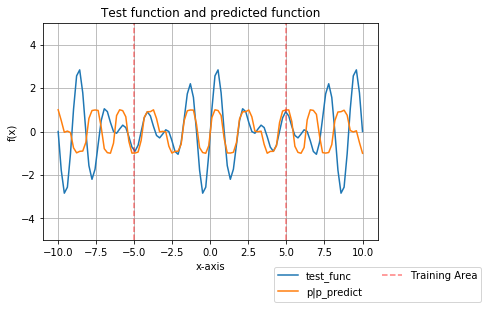

In [78]:
#--helper functions to plot results--

#range of values to display
test_func_range = (-10.0,10.0)
#step size of display
test_func_graph_points = 100
#setup the axis for np
axis = np.linspace(test_func_range[0],test_func_range[1],test_func_graph_points)

#actual values from the test function
func_values = np.asarray([test_func(val) for val in axis])

#values predicted
predicted_values = best_gp.predict(axis.reshape(-1,1))

plt.plot(axis, func_values, label = "test_func")
plt.plot(axis, predicted_values, label = "p|p_predict")

plt.axvline(x=train_range[0], label='Training Area'.format(train_range[0]), c="r", ls = "--", alpha = 0.50)
plt.axvline(x=train_range[1], c="r", ls = "--", alpha = 0.50)

plt.grid( linestyle='-')
plt.xlabel("x-axis")
plt.ylabel("f(x)")
plt.ylim(top=5,bottom=-5)
plt.title("Test function and predicted function")
pylab.legend(loc=9, bbox_to_anchor=(1, -0.1), ncol=2)
plt.show()



In [55]:
 print(best_gp._program)
best_gp.predict(np.array(0).reshape(-1,1))

mul(sub(0.039, sub(-0.658, -0.909)), div(0.675, add(0.580, X0)))


array([-0.24562048])

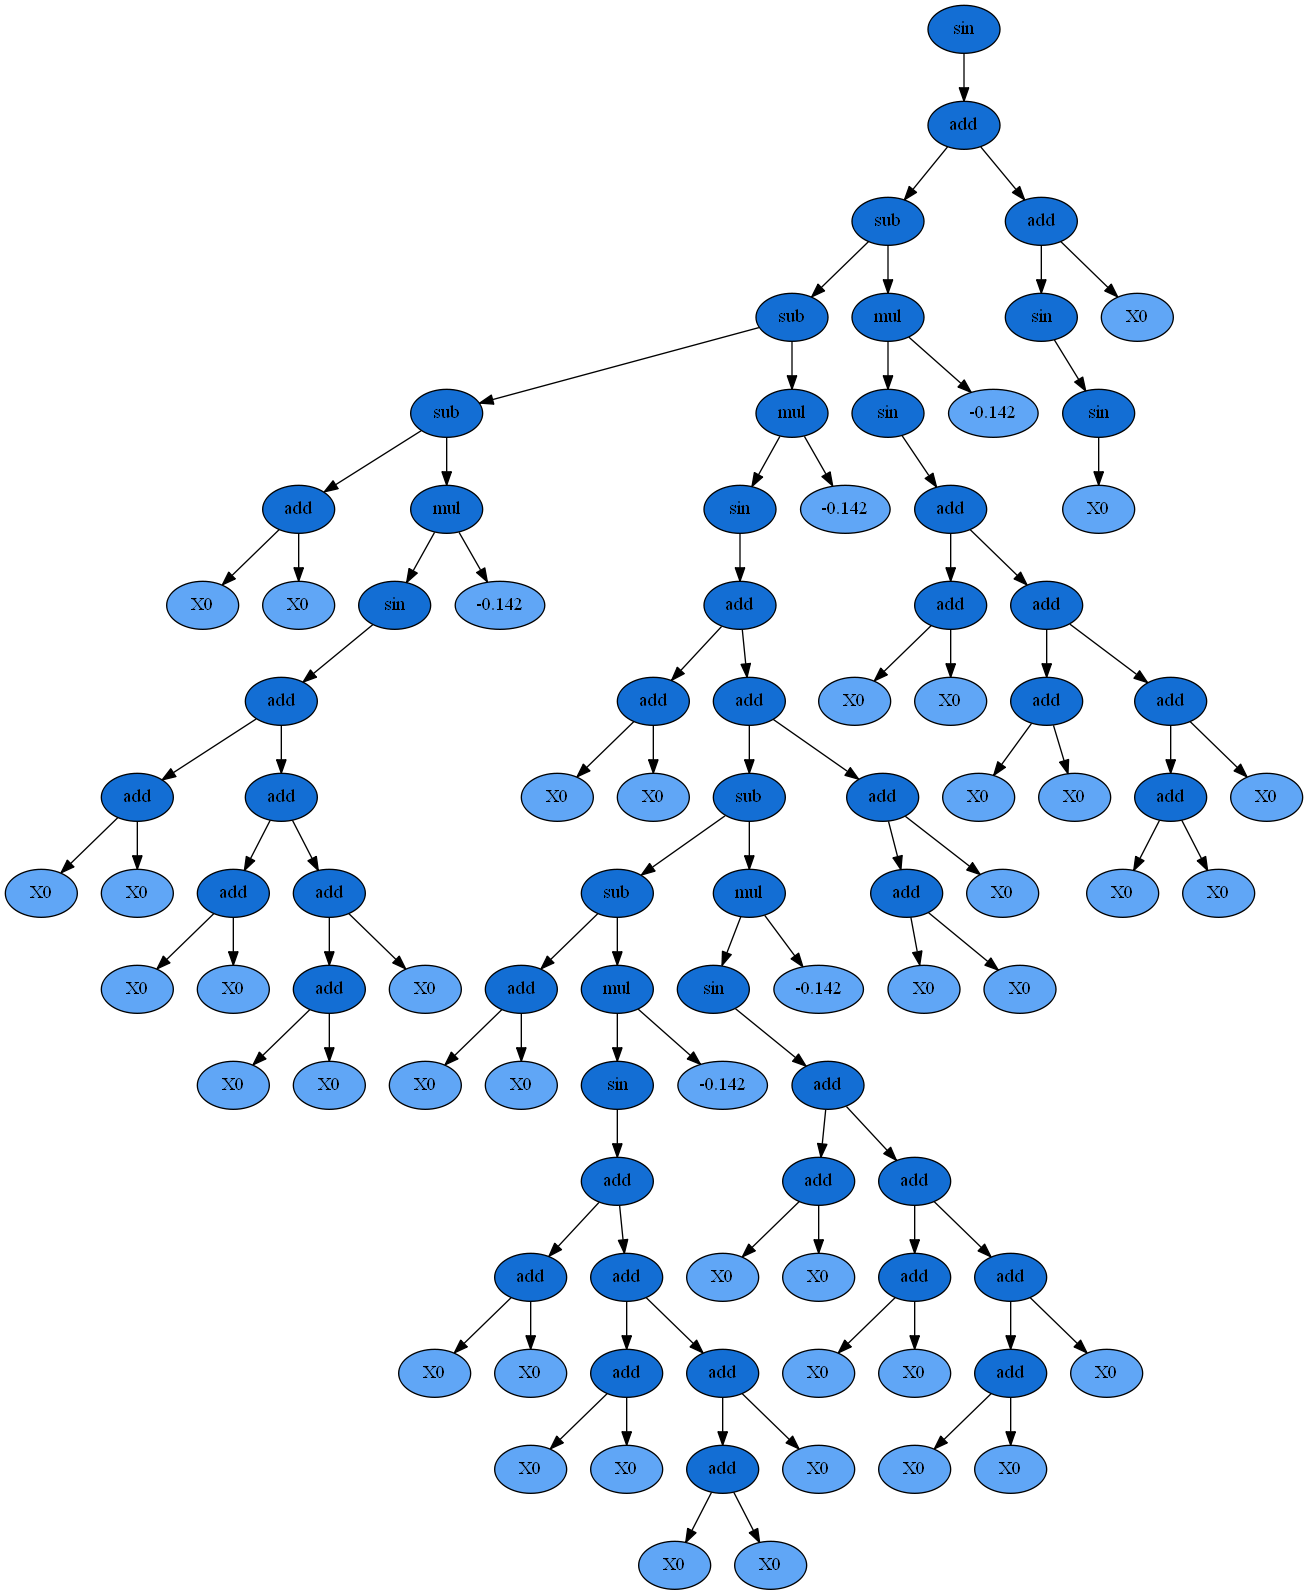

In [79]:
graph = pydotplus.graphviz.graph_from_dot_data(best_gp._program.export_graphviz())
Image(graph.create_png())